### Example Commands
#### ER
python utils/main.py --model er --dataset seq-cifar10 --n_epochs 50 --lr 0.1 --batch_size 32 --minibatch_size 32 --buffer_size 5000 --nowand 1 --non_verbose 1 --ignore_other_metrics 1 --seed 42 --concept_drift 5 --drift_severity 5 --drift_adaptation 0 --n_drifts 1 --max_classes_per_drift 0

In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np

# Functions

In [2]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [3]:
def plot_results(accuracy_array, title="Accuracy over Tasks"):
    plt.figure(figsize=(12, 6))
    for i in range(len(accuracy_array)):
        plt.plot(
            range(1, len(accuracy_array) + 1),
            accuracy_array[:, i],
            "-o",
            label=f"Avg. Acc. After T{i + 1}: {np.nansum(accuracy_array[i])/(i+1):.2f}%",
        )
        for j, value in enumerate(accuracy_array[:, i]):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(12.5, 0),
                ha="center",
                fontsize=6
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_array) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 6}, loc="lower left")

In [4]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    cumulative_averages = []

    for acc_array in accuracy_arrays:
        cum_avg_acc = [np.nansum(acc_array[i]) / (i + 1) for i in range(len(acc_array))]
        cumulative_averages.append(cum_avg_acc)

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(cumulative_averages, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 106, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [149]:
def plot_cumulative_subplots(title, accuracy_arrays, subtitles, plot_filename):
    assert len(accuracy_arrays) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    labels = ["Without Drift", "With Drift", "Drift with Full Re-learning", "Drift with Buffer Resampling"]

    cumulative_averages = []

    for acc_array in accuracy_arrays:
        cum_avg_acc = [np.nansum(acc_array[i]) / (i + 1) for i in range(len(acc_array))]
        cumulative_averages.append(cum_avg_acc)

    fig, axes = plt.subplots(1, len(accuracy_arrays) // 4, figsize=(12, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                "--o" if j == 0 else "-o",
                label=f"{labels[j]}: {cumulative_averages[4 * i + j][-1]:.2f}%",
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=14)
            axes[i].legend(prop={"size": 8}, loc="lower left")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(0, 101, 5)))

    fig.supxlabel("Task Trained On", fontsize=14)
    fig.supylabel("Accuracy (%)", fontsize=14)
    fig.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

In [6]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

# ER

## Buffer 500

### Accuracy Without Drift

In [7]:
er_500_accuracy_array_without_drift = read_results(
    "./logs/01-18-25-05-28-50-seq-cifar10-er-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 33.82, 33.86, 34.32, 34.74, 35.13
# 34.374 ± 0.5058695484015628
# plot_results(
#     er_500_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )

### Permutation Drift in Task 3

In [9]:
er_500_accuracy_array_with_drift = read_results(
    "./logs/01-18-25-23-02-01-seq-cifar10-er-buf-500-drift-5-n-1-adaptation-0.json"
)
# 31.76, 31.96, 32.28, 32.61, 33.21
# 32.364000000000004 ± 0.5121171740920233
# plot_results(
#     er_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Task 3",
# )

### Permutation Drift in Task 3 with Adaptive Re-Learning

In [10]:
er_500_accuracy_array_with_drift_full_relearning = read_results(
    "./logs/01-19-25-01-28-12-seq-cifar10-er-buf-500-drift-5-n-1-adaptation-1.json"
)
# 55.94, 56.16, 56.35, 56.95, 57.22
# 56.524 ± 0.48367757855828
# plot_results(
#     er_500_accuracy_array_with_drift_full_relearning,
#     title="Accuracy with Permutation Drift in Tasks 3 and Adaptive Re-Learning",
# )

### Permutation Drift in Task 3 with Adaptive Buffer Resampling

In [11]:
er_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./logs/01-19-25-03-00-55-seq-cifar10-er-buf-500-drift-5-n-1-adaptation-2.json"
)
# 49.08, 50.00, 50.21, 50.72, 51.84
# 50.37 ± 0.9066421565314524
# plot_results(
#     er_500_accuracy_array_with_drift_buffer_resampling,
#     title="Accuracy with Permutation Drift in Task 3 and Adaptive Buffer Sampling",
# )

### Cumulative Plots

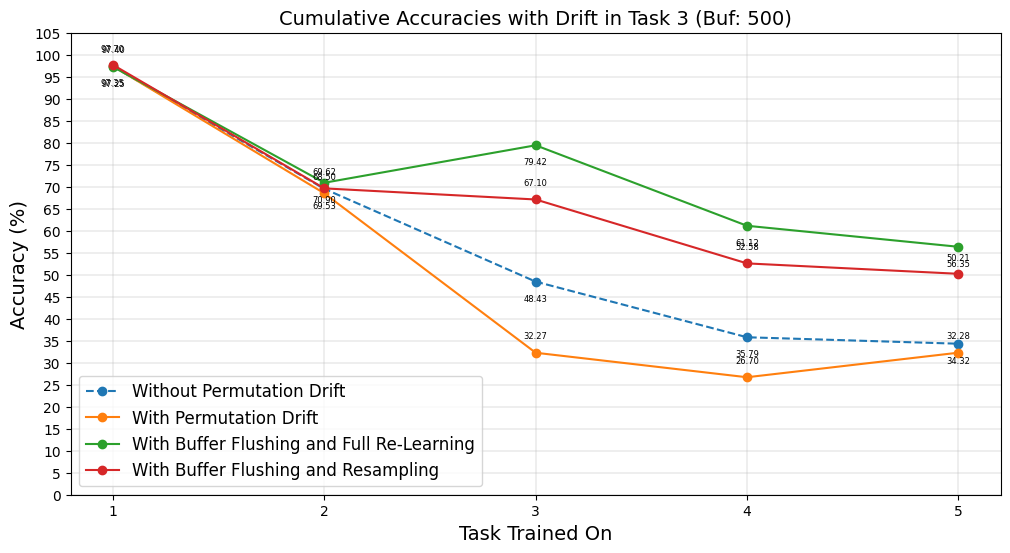

In [12]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [119]:
er_5000_accuracy_array_without_drift = read_results(
    "./logs/01-07-25-03-16-59-seq-cifar10-er-buf-5000-no-drift.json"
)
# 65.46, 65.59, 66.41, 66.56, 66.81
# 66.166 ± 0.5403184246349569
# plot_results(
#     er_5000_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )

### Permutation Drift in Task 3

In [120]:
er_5000_accuracy_array_with_drift = read_results(
    "./logs/01-07-25-07-56-20-seq-cifar10-er-buf-5000-drift-5-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 47.27, 47.33, 47.61, 47.77, 47.82
# 47.559999999999995 ± 0.22414281161795058
# plot_results(
#     er_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Task 3",
# )

### Permutation Drift in Task 3 with Adaptive Re-Learning

In [121]:
er_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./logs/01-07-25-09-28-31-seq-cifar10-er-buf-5000-drift-5-n-1-severity-5-adaptation-1-cpd-0.json"
)
# 74.5, 74.6, 75.15, 75.7, 75.81
# 75.152 ± 0.5409399227271015
# plot_results(
#     er_5000_accuracy_array_with_drift_full_relearning,
#     title="Accuracy with Permutation Drift in Tasks 3 and Adaptive Re-Learning",
# )

### Permutation Drift in Task 3 with Adaptive Buffer Resampling

In [122]:
er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./logs/01-07-25-10-19-11-seq-cifar10-er-buf-5000-drift-5-n-1-severity-5-adaptation-2-cpd-0.json"
)
# 74.19, 74.29, 74.33, 74.69, 75.01
# 74.502 ± 0.3050508154390031
# plot_results(
#     er_5000_accuracy_array_with_drift_buffer_resampling,
#     title="Accuracy with Permutation Drift in Task 3 and Adaptive Buffer Sampling",
# )

### Cumulative Plots

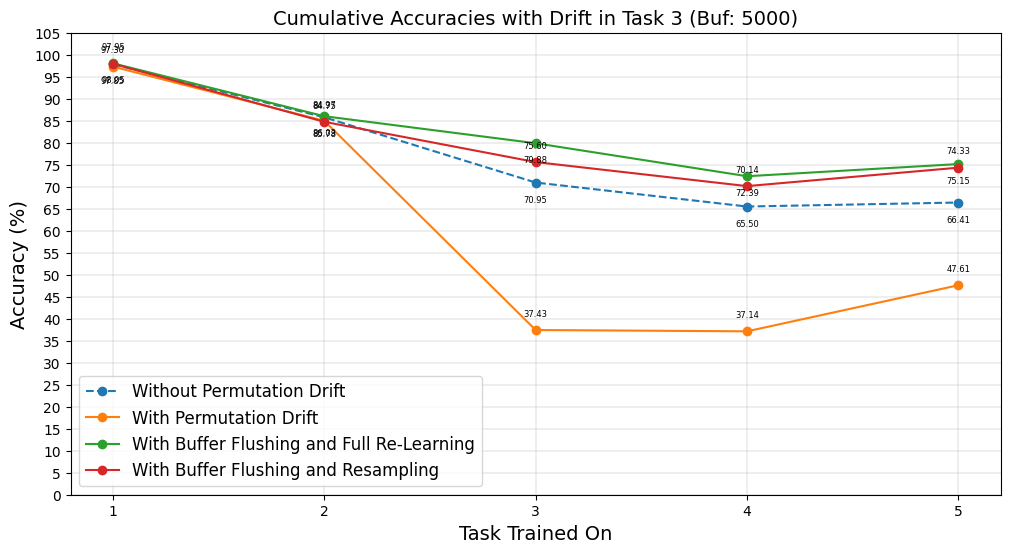

In [123]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# ER-ACE

## Buffer 500

### Accuracy Without Drift

In [18]:
er_ace_500_accuracy_array_without_drift = read_results(
    "./logs/01-18-25-05-28-50-seq-cifar10-er_ace-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 55.74, 56.39, 57.73, 57.98, 58.76
# 57.31999999999999 ± 1.0989631476987733
# plot_results(
#     er_ace_500_accuracy_array_without_drift,
#     title="ER-ACE Baseline CIL Accuracy",
# )

### Permutation Drift in Task 3

In [19]:
er_ace_500_accuracy_array_with_drift = read_results(
    "./logs/01-18-25-22-56-03-seq-cifar10-er_ace-buf-500-drift-5-n-1-adaptation-0.json"
)
# 36.25, 37.02, 37.92, 38.44, 38.77
# 37.68 ± 0.927771523598348
# plot_results(
#     er_ace_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Task 3",
# )

### Permutation Drift in Task 3 with Adaptive Re-Learning

In [20]:
er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
    "./logs/01-19-25-01-21-29-seq-cifar10-er_ace-buf-500-drift-5-n-1-adaptation-1.json"
)
# 62.72, 63.26, 63.47, 64.02
# 63.36749999999999 ± 0.4655843103026552
# plot_results(
#     er_ace_500_accuracy_array_with_drift_full_relearning,
#     title="Accuracy with Permutation Drift in Task 3 and Adaptive Re-Learning",
# )

### Permutation Drift in Task 3 with Adaptive Buffer Resampling

In [21]:
er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./logs/01-19-25-18-34-18-seq-cifar10-er_ace-buf-500-drift-5-n-1-adaptation-2.json"
)
# 59.62, 59.76, 60.38, 61.15, 61.57
# 60.496 ± 0.762065613972971
# plot_results(
#     er_ace_500_accuracy_array_with_drift_buffer_resampling,
#     title="Accuracy with Permutation Drift in Task 3 and Adaptive Buffer Sampling",
# )

### Cumulative Plots

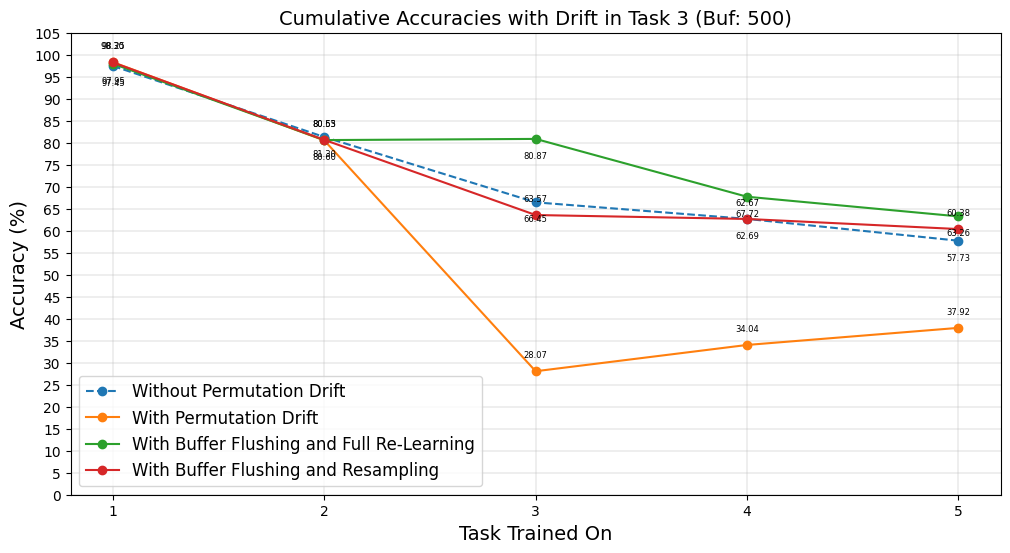

In [22]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 500)",
    [
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [124]:
er_ace_5000_accuracy_array_without_drift = read_results(
    "./logs/01-14-25-23-00-53-seq-cifar10-er_ace-buf-5000-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 68.05, 68.51, 68.72, 68.74, 69.78
# 68.75999999999999 ± 0.5672741841473141
# plot_results(
#     er_ace_5000_accuracy_array_without_drift,
#     title="ER-ACE Baseline CIL Accuracy",
# )

### Permutation Drift in Task 3

In [125]:
er_ace_5000_accuracy_array_with_drift = read_results(
    "./logs/01-14-25-23-01-52-seq-cifar10-er_ace-buf-5000-drift-5-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 44.06, 44.22, 44.64, 44.90, 45.27
# 44.61800000000001 ± 0.4415608678313787
# plot_results(
#     er_ace_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Task 3",
# )

### Permutation Drift in Task 3 with Adaptive Re-Learning

In [126]:
er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./logs/01-14-25-23-33-58-seq-cifar10-er_ace-buf-5000-drift-5-n-1-severity-5-adaptation-1-cpd-0.json"
)
# 73.64, 73.84, 73.92, 74.19, 74.39
# 73.99600000000001 ± 0.26446927987953456
# plot_results(
#     er_ace_5000_accuracy_array_with_drift_full_relearning,
#     title="Accuracy with Permutation Drift in Task 3 and Adaptive Re-Learning",
# )

### Permutation Drift in Task 3 with Adaptive Buffer Resampling

In [127]:
er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./logs/01-14-25-23-10-23-seq-cifar10-er_ace-buf-5000-drift-5-n-1-severity-5-adaptation-2-cpd-0.json"
)
# 72.52, 73.1, 73.23, 73.26, 73.28
# 73.078 ± 0.28596503282744473
# plot_results(
#     er_ace_5000_accuracy_array_with_drift_buffer_resampling,
#     title="Accuracy with Permutation Drift in Task 3 and Adaptive Buffer Sampling",
# )

### Cumulative Plots

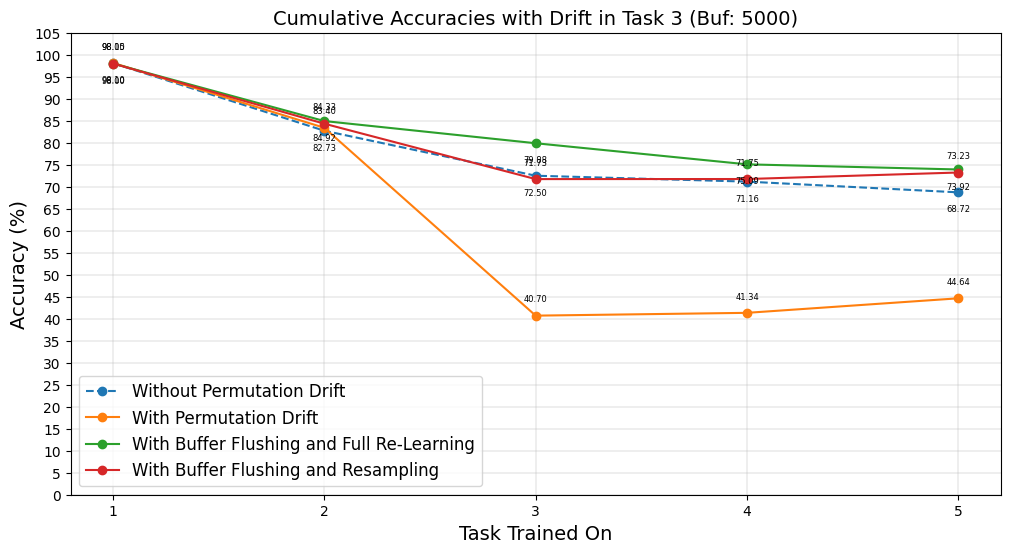

In [128]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 5000)",
    [
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# DER

## Buffer 500

### Accuracy Without Drift

In [37]:
der_500_accuracy_array_without_drift = read_results(
    "./logs/01-18-25-03-50-03-seq-cifar10-der-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 38.47, 39.13, 39.71, 40.41, 41.37
# 39.818 ± 1.0061093379946324
# plot_results(
#     der_500_accuracy_array_without_drift,
#     title="DER Baseline CIL Accuracy",
# )

### Permutation Drift in Task 3

In [39]:
der_500_accuracy_array_with_drift = read_results(
    "./logs/01-18-25-23-06-58-seq-cifar10-der-buf-500-drift-5-n-1-adaptation-0.json"
)
# 34.17, 35.53, 36.66, 37.57, 38.21
# 36.428000000000004 ± 1.444886154684859
# plot_results(
#     der_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Task 3",
# )

### Permutation Drift in Task 3 with Adaptive Re-Learning

In [41]:
der_500_accuracy_array_with_drift_full_relearning = read_results(
    "./logs/01-19-25-01-41-13-seq-cifar10-der-buf-500-drift-5-n-1-adaptation-1.json"
)
# 52.33, 54.19, 58.24, 58.35
# 55.777499999999996 ± 2.6022622369776665
# plot_results(
#     der_500_accuracy_array_with_drift_full_relearning,
#     title="Accuracy with Permutation Drift in Task 3 and Adaptive Re-Learning",
# )

### Permutation Drift in Task 3 with Adaptive Buffer Resampling

In [43]:
der_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./logs/01-19-25-18-05-22-seq-cifar10-der-buf-500-drift-5-n-1-adaptation-2.json"
)
# 43.06, 44.06, 44.95, 45.58, 46.78
# 44.885999999999996 ± 1.2719685530703966
# plot_results(
#     der_500_accuracy_array_with_drift_buffer_resampling,
#     title="Accuracy with Permutation Drift in Task 3 and Adaptive Buffer Sampling",
# )

### Cumulative Plots

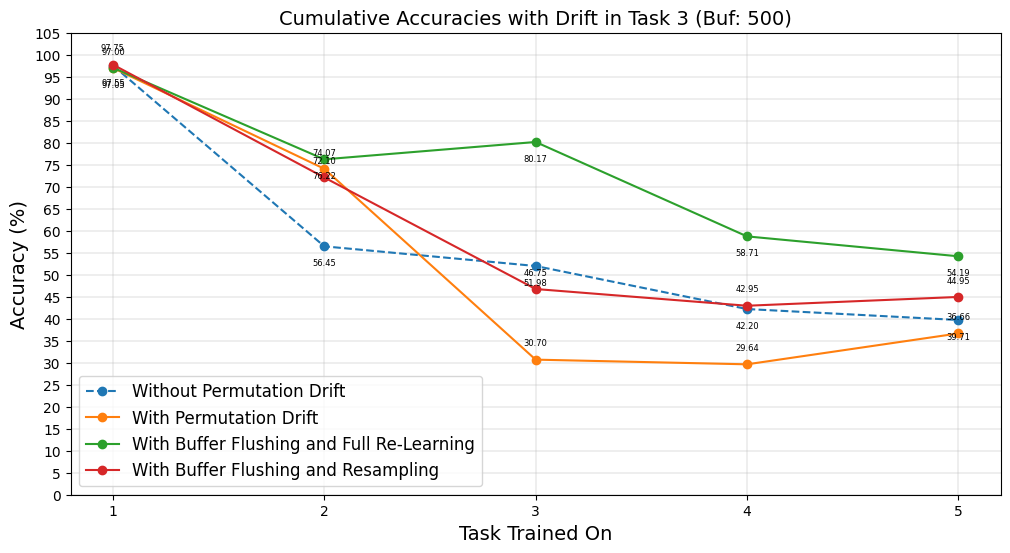

In [32]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 500)",
    [
        der_500_accuracy_array_without_drift,
        der_500_accuracy_array_with_drift,
        der_500_accuracy_array_with_drift_full_relearning,
        der_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [129]:
der_5000_accuracy_array_without_drift = read_results(
    "./logs/01-19-25-18-23-22-seq-cifar10-der-buf-5000-drift-6-n-1-adaptation-0.json"
)
# 62.23, 62.42, 62.56, 63.37, 63.95
# 62.906000000000006 ± 0.6508640411022881
# plot_results(
#     der_5000_accuracy_array_without_drift,
#     title="DER Baseline CIL Accuracy",
# )

### Permutation Drift in Task 3

In [130]:
der_5000_accuracy_array_with_drift = read_results(
    "./logs/01-19-25-23-00-03-seq-cifar10-der-buf-5000-drift-5-n-1-adaptation-0.json"
)
# 46.44, 46.72, 46.94, 46.96, 47.58
# 46.928 ± 0.37621270579288
# plot_results(
#     der_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Task 3",
# )

### Permutation Drift in Task 3 with Adaptive Re-Learning

In [131]:
der_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./logs/01-20-25-05-20-55-seq-cifar10-der-buf-5000-drift-5-n-1-adaptation-1.json"
)
# 64.51, 64.73, 64.91, 67.72, 68.93
# 66.16 ± 1.8130857674142178
# plot_results(
#     der_5000_accuracy_array_with_drift_full_relearning,
#     title="Accuracy with Permutation Drift in Task 3 and Adaptive Re-Learning",
# )

### Permutation Drift in Task 3 with Adaptive Buffer Resampling

In [132]:
der_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./logs/01-20-25-08-28-34-seq-cifar10-der-buf-5000-drift-5-n-1-adaptation-2.json"
)
# 58.34, 58.49, 58.60, 58.77, 60.77
# 58.99400000000001 ± 0.8990350382493446
# plot_results(
#     der_5000_accuracy_array_with_drift_buffer_resampling,
#     title="Accuracy with Permutation Drift in Task 3 and Adaptive Buffer Sampling",
# )

### Cumulative Plots

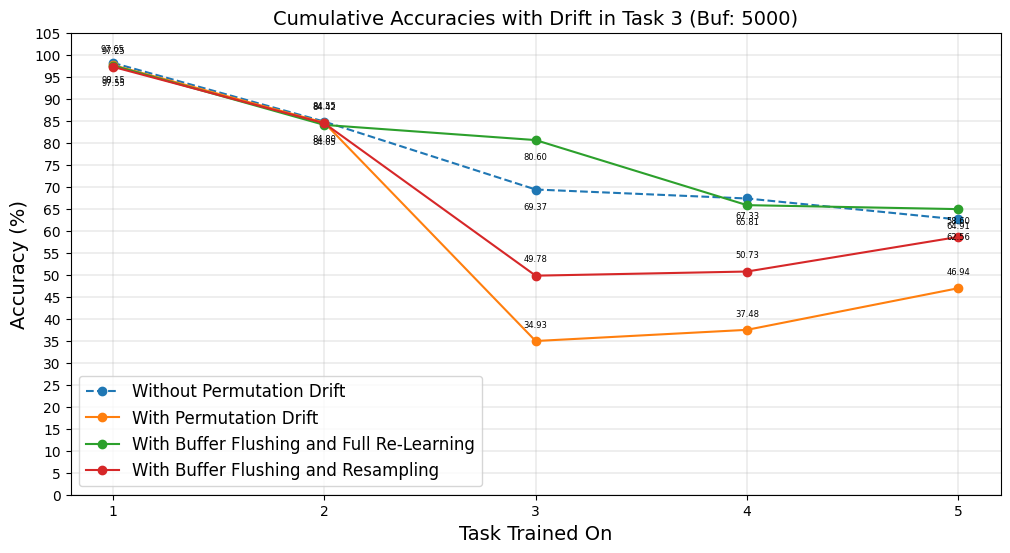

In [133]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 5000)",
    [
        der_5000_accuracy_array_without_drift,
        der_5000_accuracy_array_with_drift,
        der_5000_accuracy_array_with_drift_full_relearning,
        der_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# DER++

## Buffer 500

### Accuracy Without Drift

In [91]:
derpp_500_accuracy_array_without_drift = read_results(
    "./logs/01-18-25-19-53-51-seq-cifar10-derpp-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 40.35, 41.20, 41.61, 41.63, 42.23
# 41.404 ± 0.6210185182424098
# plot_results(
#     derpp_500_accuracy_array_without_drift,
#     title="DER++ Baseline CIL Accuracy",
# )

### Permutation Drift in Task 3

In [92]:
derpp_500_accuracy_array_with_drift = read_results(
    "./logs/01-19-25-01-40-51-seq-cifar10-derpp-buf-500-drift-5-n-1-adaptation-0.json"
)
# 35.85, 37.12, 38.15, 38.60, 39.44
# 37.832 ± 1.241924313313818
# plot_results(
#     derpp_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Task 3",
# )

### Permutation Drift in Task 3 with Adaptive Re-Learning

In [93]:
derpp_500_accuracy_array_with_drift_full_relearning = read_results(
    "./logs/01-19-25-20-10-13-seq-cifar10-derpp-buf-500-drift-5-n-1-adaptation-1.json"
)
# 59.94, 61.09, 61.97, 62.82, 63.87
# 61.938 ± 1.3581369592202395
# plot_results(
#     derpp_500_accuracy_array_with_drift_full_relearning,
#     title="Accuracy with Permutation Drift in Task 3 and Adaptive Re-Learning",
# )

### Permutation Drift in Task 3 with Adaptive Buffer Resampling

In [94]:
derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./logs/01-20-25-04-17-47-seq-cifar10-derpp-buf-500-drift-5-n-1-adaptation-2.json"
)
# 50.92, 55.55, 55.69, 55.73, 56.73
# 54.924 ± 2.045576691302478
# plot_results(
#     derpp_500_accuracy_array_with_drift_buffer_resampling,
#     title="Accuracy with Permutation Drift in Task 3 and Adaptive Buffer Sampling",
# )

### Cumulative Plots

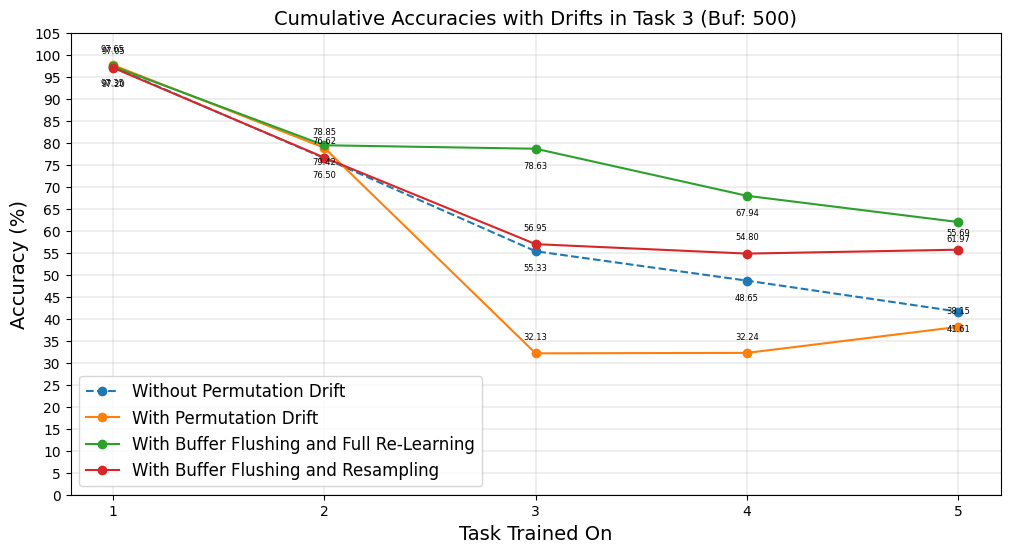

In [95]:
plot_cumulative_results(
    "Cumulative Accuracies with Drifts in Task 3 (Buf: 500)",
    [
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [134]:
derpp_5000_accuracy_array_without_drift = read_results(
    "./logs/01-15-25-02-01-27-seq-cifar10-derpp-buf-5000-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 63.82, 64.41, 65.27, 66.30, 66.07
# 65.174 ± 0.9483585819720287
# plot_results(
#     derpp_5000_accuracy_array_without_drift,
#     title="DER++ Baseline CIL Accuracy",
# )

### Permutation Drift in Task 3

In [135]:
derpp_5000_accuracy_array_with_drift = read_results(
    "./logs/01-15-25-02-11-26-seq-cifar10-derpp-buf-5000-drift-5-n-1-severity-5-adaptation-0-cpd-0.json"
)
# 46.12, 46.27, 46.76, 46.81, 46.96
# 46.584 ± 0.32781702213277497
# plot_results(
#     derpp_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Task 3",
# )

### Permutation Drift in Task 3 with Adaptive Re-Learning

In [136]:
derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./logs/01-15-25-02-51-37-seq-cifar10-derpp-buf-5000-drift-5-n-1-severity-5-adaptation-1-cpd-0.json"
)
# 75.50, 75.54, 76.24, 76.31, 76.32
# 75.982 ± 0.37843889863490215
# plot_results(
#     derpp_5000_accuracy_array_with_drift_full_relearning,
#     title="Accuracy with Permutation Drift in Task 3 and Adaptive Re-Learning",
# )

### Permutation Drift in Task 3 with Adaptive Buffer Resampling

In [137]:
derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./logs/01-15-25-02-23-16-seq-cifar10-derpp-buf-5000-drift-5-n-1-severity-5-adaptation-2-cpd-0.json"
)
# 74.03, 74.04, 74.22, 74.25, 74.78
# 74.26399999999998 ± 0.2732471408816561
# plot_results(
#     derpp_5000_accuracy_array_with_drift_buffer_resampling,
#     title="Accuracy with Permutation Drift in Task 3 and Adaptive Buffer Sampling",
# )

### Cumulative Plots

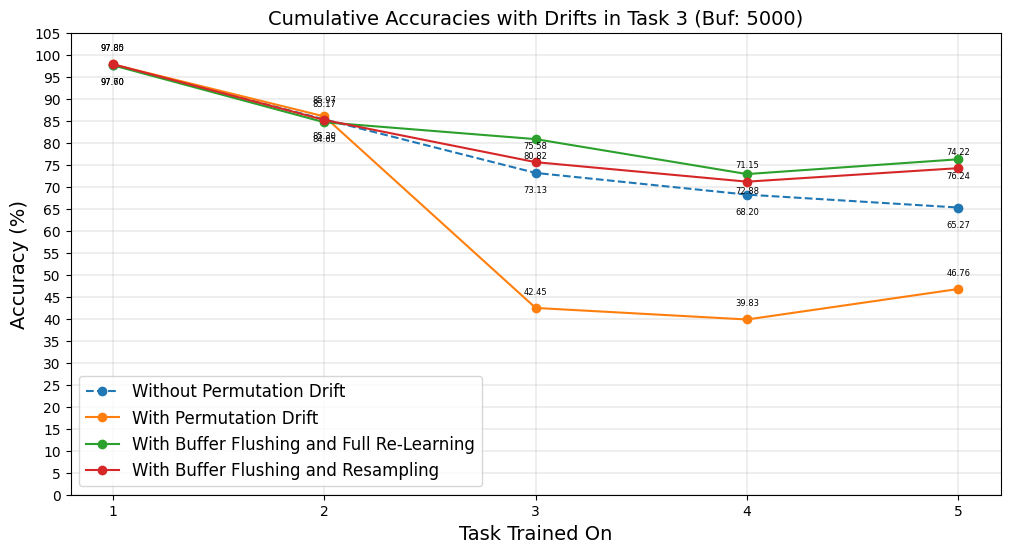

In [138]:
plot_cumulative_results(
    "Cumulative Accuracies with Drifts in Task 3 (Buf: 5000)",
    [
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

In [ ]:
values = []
f"{np.mean(values)} ± {np.std(values)}"

## Buffer 500

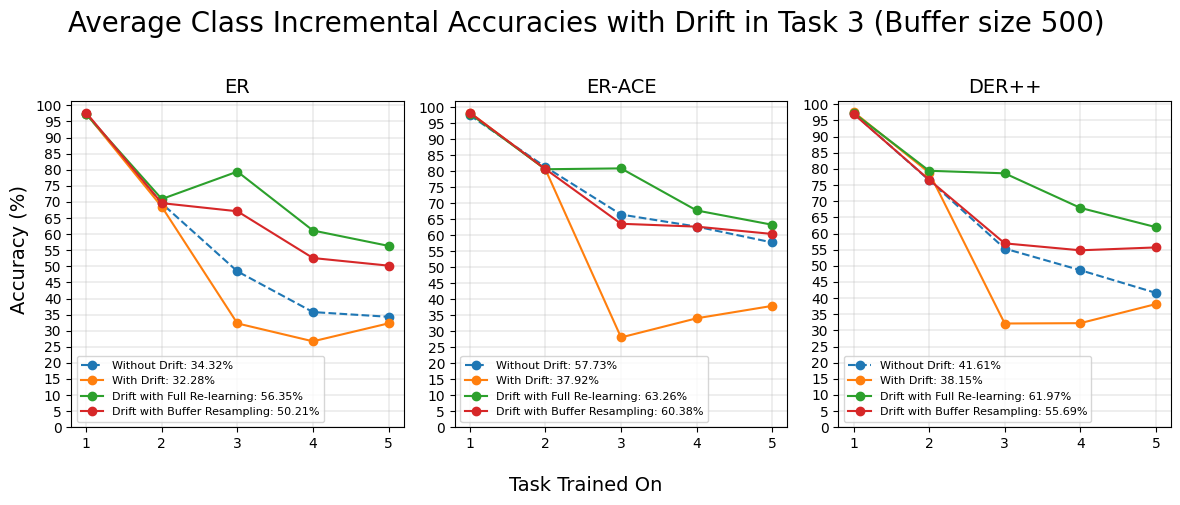

In [151]:
plot_cumulative_subplots(
    "Average Class Incremental Accuracies with Drift in Task 3 (Buffer size 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        # der_500_accuracy_array_without_drift,
        # der_500_accuracy_array_with_drift,
        # der_500_accuracy_array_with_drift_full_relearning,
        # der_500_accuracy_array_with_drift_buffer_resampling,
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "ER",
        "ER-ACE",
        # "DER",
        "DER++",
    ],
    plot_filename="CIFAR10_Buff_500_n_1.pdf",
)

## Buffer 5000

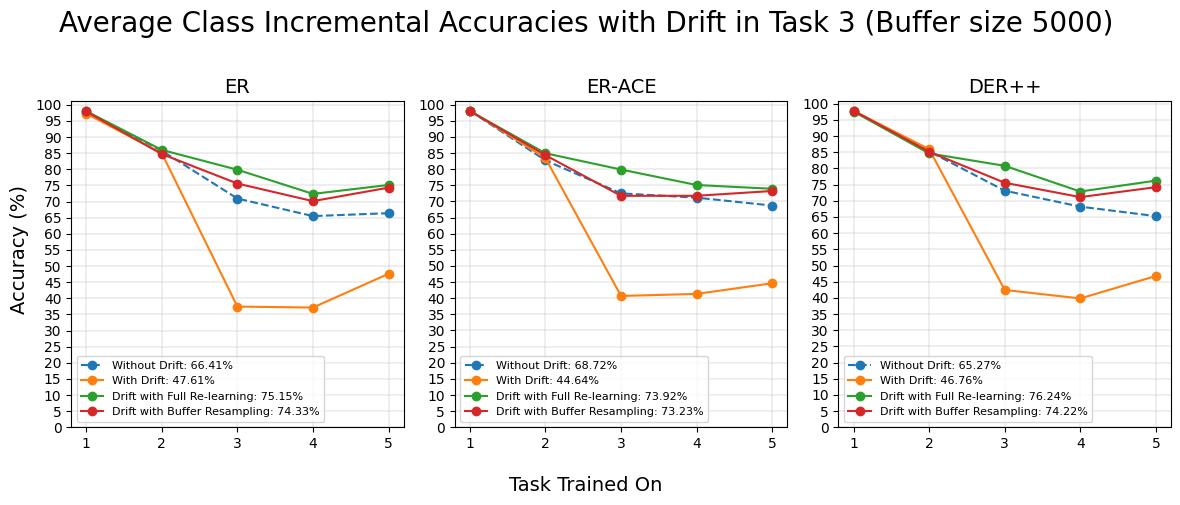

In [153]:
plot_cumulative_subplots(
    "Average Class Incremental Accuracies with Drift in Task 3 (Buffer size 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
        # der_5000_accuracy_array_without_drift,
        # der_5000_accuracy_array_with_drift,
        # der_5000_accuracy_array_with_drift_full_relearning,
        # der_5000_accuracy_array_with_drift_buffer_resampling,
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "ER",
        "ER-ACE",
        # "DER",
        "DER++",
    ],
    plot_filename="CIFAR10_Buff_5000_n_1.pdf",
)